# Test MCS and Examples

This is a notebook for testing MCS and show examples for MCS

## Import everything

modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch and other standard modules

In [2]:
%matplotlib inline
import random
import torch
from torch.utils import data
from d2l import torch as d2l

import MCS and CostFunc

In [3]:
import MCS
import CostFunc
from MCS import MCSOptimizer
from CostFunc import GradFreeMSELoss
from CostFunc import StandardSNN

## Linear Regression

### Genrate training data

In [4]:
def synthetic_data(w, b, num_examples):  
    """y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.3811, -0.6712]) 
label: tensor([7.2489])


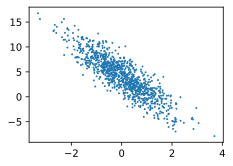

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### Reading the data via torch API

In [8]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Generate a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [9]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [10]:
next(iter(data_iter))

[tensor([[-0.1914, -0.3232],
         [-0.8221,  0.3063],
         [ 0.7312, -0.6991],
         [-1.2185, -0.4733],
         [ 0.4424, -0.9333],
         [ 2.1909,  1.2617],
         [ 1.6525,  0.3541],
         [ 1.1974,  0.3465],
         [-0.6034,  0.1322],
         [-1.2327, -0.1818]]),
 tensor([[4.9173],
         [1.5189],
         [8.0494],
         [3.3897],
         [8.2563],
         [4.2872],
         [6.2924],
         [5.4188],
         [2.5485],
         [2.3337]])]

## Define a model

### Function for initialize weight function

In [11]:
def getParams(inputSize,numHiddens):
    w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return (w,b)

### Linear Net Model

In [12]:
class LinearNet(StandardSNN):
    '''a standard net with linear regression'''
    def __init__(self,getParams,inputSize,numHiddens):
        self.params=getParams(inputSize,numHiddens)

    def __call__(self,X:torch.Tensor):
        return self.call_with_weight(X,self.params)

    def call_with_weight(self,X:torch.Tensor,weight:tuple):
        w,b=weight
        return torch.matmul(X,w)+b

In [13]:
net=LinearNet(getParams,2,1)

### Loss function

In [14]:
lossFunc=GradFreeMSELoss(net,reduction='none')

### MCS optimizer

In [15]:
net=LinearNet(getParams,2,1)
mcs=MCSOptimizer(net.params,lossFunc,data_iter,\
                    maxLevyStepSize=0.1,\
                    nestNum=6)

In [16]:
num_epochs=3
for epoch in range(num_epochs):
    mcs.step()
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.004511
epoch 2, loss 0.003146
epoch 3, loss 0.000819


In [17]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 2.0012],
        [-3.4171]], requires_grad=True) tensor([4.1797], requires_grad=True)
loss of w: tensor([-0.0012,  0.0171], grad_fn=<SubBackward0>)
loss of b: tensor([0.0203], grad_fn=<RsubBackward1>)


### Standard sgd

In [18]:
net=LinearNet(getParams,2,1)

In [19]:
def squared_loss(y_hat, y):  #@save
    """L2 loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [20]:
def sgd(params, lr, batch_size):  
    """sgd"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [21]:
lr = 0.03
num_epochs = 3
loss = squared_loss

In [22]:
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = lossFunc(net(X), y)
        l.sum().backward()
        sgd(net.params, lr, batch_size) 
    with torch.no_grad():
        train_l = lossFunc(net(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000278
epoch 2, loss 0.000105
epoch 3, loss 0.000104


In [23]:
w,b=net.params
print(w,b)
print(f'loss of w: {true_w - w.reshape(true_w.shape)}')
print(f'loss of b: {true_b - b}')

tensor([[ 2.0005],
        [-3.4005]], requires_grad=True) tensor([4.1999], requires_grad=True)
loss of w: tensor([-0.0005,  0.0005], grad_fn=<SubBackward0>)
loss of b: tensor([7.6294e-05], grad_fn=<RsubBackward1>)
